In [26]:
import openmeteo_requests
import requests_cache
from retry_requests import retry
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hopsworks

In [49]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
# Get data over a year
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 59.3294,
	"longitude": 18.0687,
	"start_date": "2023-01-01",
	"end_date": "2023-12-25",
	"hourly": ["temperature_2m", "apparent_temperature", "precipitation", "rain", "snowfall", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "wind_gusts_10m"],
	"timezone": "Europe/Berlin"
}
responses = openmeteo.weather_api(url, params=params)


In [50]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_rain = hourly.Variables(3).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(4).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(5).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(6).ValuesAsNumpy()
hourly_cloud_cover_low = hourly.Variables(7).ValuesAsNumpy()
hourly_cloud_cover_mid = hourly.Variables(8).ValuesAsNumpy()
hourly_cloud_cover_high = hourly.Variables(9).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(10).ValuesAsNumpy()
hourly_wind_speed_100m = hourly.Variables(11).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(12).ValuesAsNumpy()
hourly_wind_direction_100m = hourly.Variables(13).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(14).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s"),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
hourly_data["cloud_cover_high"] = hourly_cloud_cover_high
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_direction_100m"] = hourly_wind_direction_100m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates 59.29701232910156°E 18.163265228271484°N
Elevation 24.0 m asl
Timezone b'Europe/Berlin' b'CET'
Timezone difference to GMT+0 3600 s
                    date  temperature_2m  apparent_temperature  precipitation  \
0    2022-12-31 23:00:00           2.765             -1.600582            0.0   
1    2023-01-01 00:00:00           2.365             -1.857766            0.0   
2    2023-01-01 01:00:00           1.615             -2.130880            0.0   
3    2023-01-01 02:00:00           0.765             -2.911085            0.0   
4    2023-01-01 03:00:00           0.165             -3.455367            0.0   
...                  ...             ...                   ...            ...   
8611 2023-12-25 18:00:00          -0.185             -3.219042            0.2   
8612 2023-12-25 19:00:00          -0.235             -3.228180            0.2   
8613 2023-12-25 20:00:00          -0.385             -3.208137            0.2   
8614 2023-12-25 21:00:00          -0.535       

In [51]:
# Find nan items, the data is clean
print(hourly_dataframe[hourly_dataframe.isna().any(axis=1)])
# Check distribution of variables
hourly_dataframe.describe()

Empty DataFrame
Columns: [date, temperature_2m, apparent_temperature, precipitation, rain, snowfall, surface_pressure, cloud_cover, cloud_cover_low, cloud_cover_mid, cloud_cover_high, wind_speed_10m, wind_speed_100m, wind_direction_10m, wind_direction_100m, wind_gusts_10m]
Index: []


,date,temperature_2m,apparent_temperature,precipitation,rain,snowfall,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m
count,8616,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000
mean,2023-06-29 10:30:00,7.349825,4.389732,0.090460,0.070845,0.013763,1008.120483,55.359299,39.904247,34.146706,41.824860,12.474373,21.931971,200.155685,199.512848,27.308689
min,2022-12-31 23:00:00,-15.385000,-19.922291,0.000000,0.000000,0.000000,959.924866,0.000000,0.000000,0.000000,0.000000,0.360000,0.509117,0.954824,0.636578,2.160000
25%,2023-03-31 16:45:00,0.565000,-3.661869,0.000000,0.000000,0.000000,999.987579,13.500000,0.000000,0.000000,0.000000,8.891344,16.075521,133.651608,129.093857,19.080000
50%,2023-06-29 10:30:00,6.215000,2.793172,0.000000,0.000000,0.000000,1009.024719,58.200001,13.000000,8.000000,16.000000,12.069400,21.485697,212.781876,213.690094,26.280001
75%,2023-09-27 04:15:00,14.865000,13.861199,0.000000,0.000000,0.000000,1017.081131,100.000000,100.000000,84.000000,99.000000,15.294703,27.002399,273.900421,274.763550,34.200001
max,2023-12-25 22:00:00,26.865000,26.756815,10.200000,10.200000,2.450000,1036.735840,100.000000,100.000000,100.000000,100.000000,34.606842,57.599998,360.000000,360.000000,74.159996
std,NaN,8.328798,9.812714,0.387473,0.366036,0.084954,12.729254,40.372108,44.249447,41.474903,44.685829,5.272028,8.851148,96.528526,97.387726,11.567465


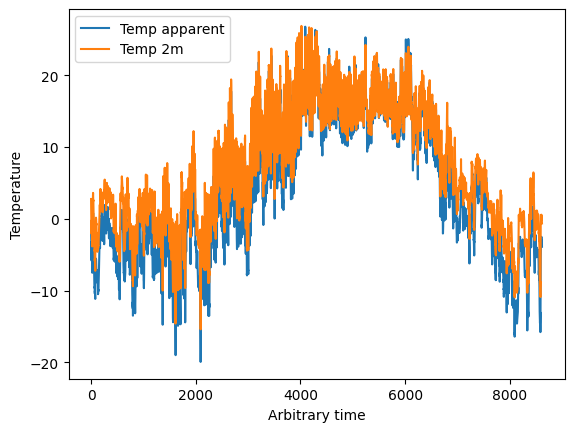

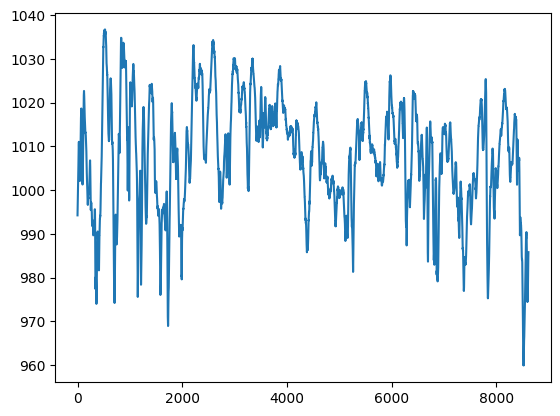

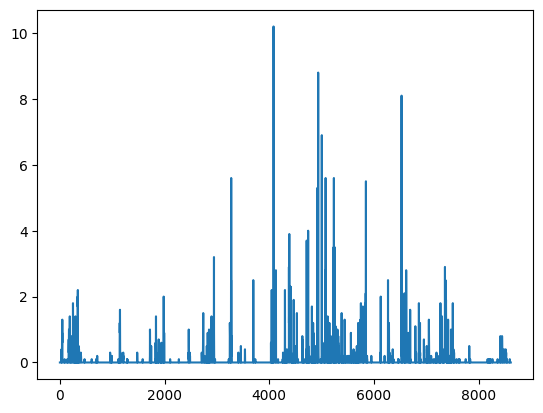

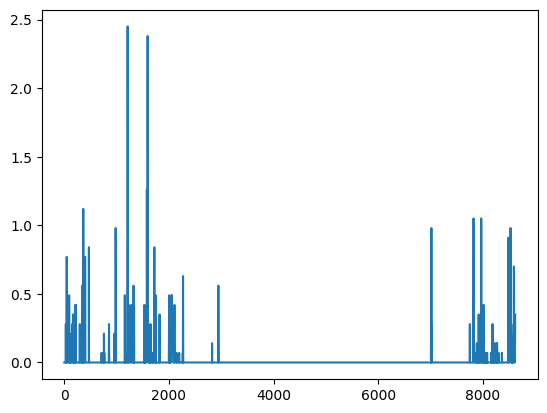

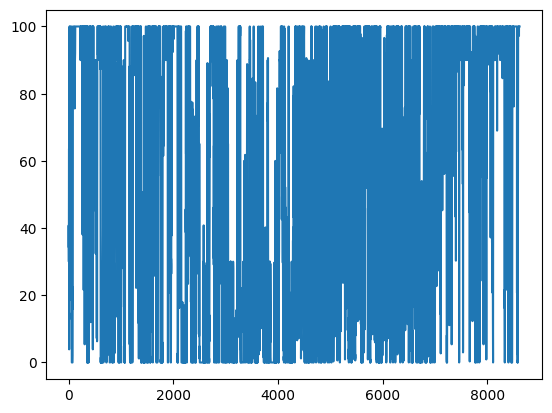

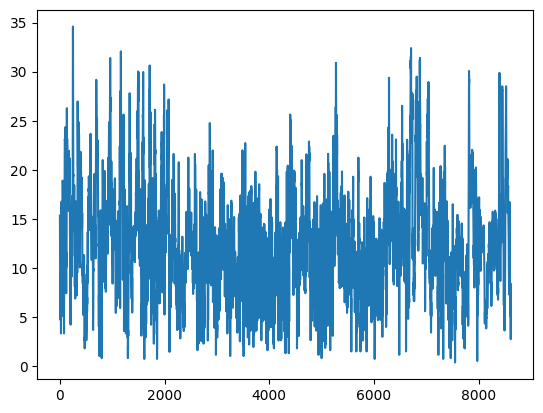

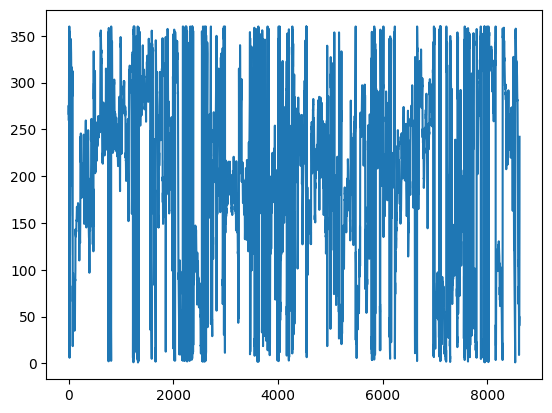

In [57]:
# Try plotting the temperature to see if it makes sense
plot_x = [i for i in range(len(hourly_data["apparent_temperature"]))]
plt.plot(plot_x, hourly_data["apparent_temperature"], label='Temp apparent')
plt.plot(plot_x, hourly_data["temperature_2m"], label='Temp 2m')
plt.legend()
plt.xlabel('Arbitrary time')
plt.ylabel('Temperature')
plt.show()
# We can see that the temperature is much higher during summer, everything looks good
# Let's check pressure, snow, clouds and rain.

plt.plot(plot_x, hourly_data['surface_pressure'], label='Temp apparent')
plt.show()

plt.plot(plot_x, hourly_data['rain'], label='Temp apparent')
plt.show()

plt.plot(plot_x, hourly_data['snowfall'], label='Temp apparent')
plt.show()

plt.plot(plot_x, hourly_data['cloud_cover'], label='Temp apparent')
plt.show()

plt.plot(plot_x, hourly_data['wind_speed_10m'], label='Temp apparent')
plt.show()

plt.plot(plot_x, hourly_data['wind_direction_10m'], label='Temp apparent')
plt.show()

<Axes: >

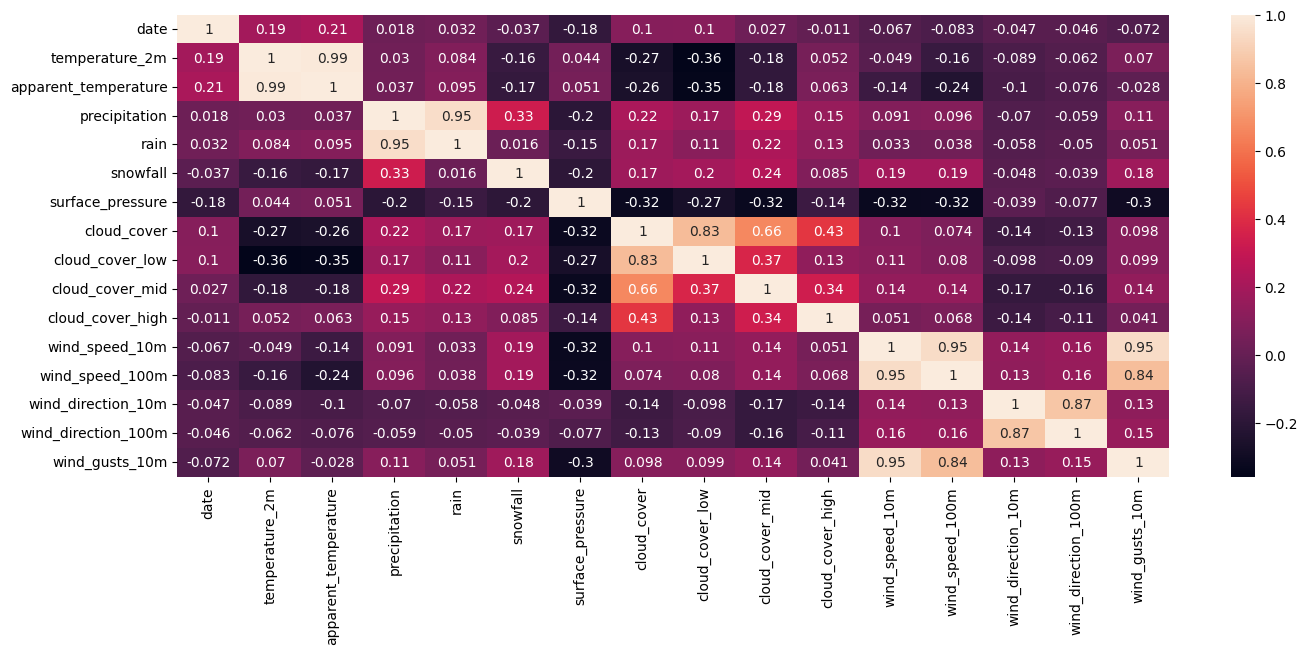

In [53]:
plt.figure(figsize=(16, 6))
sns.heatmap(hourly_dataframe.corr(), annot=True)

In [39]:
# We see that windspeeds/windgusts at different heights correlate highly, and thus isn't as interesting. We remove these.
hourly_dataframe = hourly_dataframe.drop(columns=['wind_speed_100m', 'wind_direction_100m', 'wind_gusts_10m'])
# Furthermore, the different cloud coverage - low, mid and high are not very interesting either. We remove these and keep the cloud coverage variable
hourly_dataframe = hourly_dataframe.drop(columns=['cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high'])
# We'll remove precipition as it is a combination of rain and snowfall.
hourly_dataframe = hourly_dataframe.drop(columns=['precipitation'])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/cheesy/miniconda3/envs/ml/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1146/1040515240.py", line 2, in <module>
    hourly_dataframe = hourly_dataframe.drop(columns=['wind_speed_100m', 'wind_direction_100m', 'wind_gusts_10m'])
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cheesy/miniconda3/envs/ml/lib/python3.11/site-packages/pandas/core/frame.py", line 5347, in drop
    axis : {0 or 'index', 1 or 'columns'}, default 0
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cheesy/miniconda3/envs/ml/lib/python3.11/site-packages/pandas/core/generic.py", line 4711, in drop
    2  3  5
            
  File "/home/cheesy/miniconda3/envs/ml/lib/python3.11/site-packages/pandas/core/generic.py", line 4753, in _drop_axis
    Returns
    

## Feature store
Add the fine-tuned dataset to the feature store.

In [58]:
project = hopsworks.login()
fs = project.get_feature_store()

Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated
Connected. Call `.close()` to terminate connection gracefully.


RestAPIError: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/variables/docker_base_image_python_version). Server response: 
HTTP code: 401, HTTP reason: Unauthorized, body: b'{"errorCode":200003,"errorMsg":"Invalidated Api key."}', error code: 200003, error msg: Invalidated Api key., user msg: 

In [ ]:
# Copied from earlier assignment, choose relevant variables.
# This needs to be changed before anything is uploaded!
weather_fg = fs.get_or_create_feature_group(
    name="weather",
    version=1,
    primary_key=["type", "volatile_acidity", "citric_acid", "chlorides", 'total_sulfur_dioxide', 'alcohol', 'density'],
    description="Wine quality dataset")
hourly_dataframe = hourly_dataframe.rename(columns={'volatile acidity': 'volatile_acidity', 'citric acid': 'citric_acid', 'total sulfur dioxide': 'total_sulfur_dioxide'})
weather_fg.insert(hourly_dataframe)

